## CUDA and SPLIT


In [1]:
from torch.utils.data import DataLoader
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
SPLIT_BY = 'arb'

## Calculate Normalization Vectors

In [2]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset
from torch.utils.data import DataLoader

class StatsRecorder:
    def __init__(self, red_dims=(0,1,2)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n


root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/2d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=8, shuffle=True)

# create recorders
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,1))

# step through the training dataset
with torch.no_grad():
    
    for idx,(x,y) in enumerate(iter(train_dataloader)):
        # print(x.shape)
        # print((torch.mean(x, axis=1)))
        # update normalization statistics
        # x=(x-torch.mean(x))/torch.std(x)
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
global_mean,global_std = global_stats.mean,global_stats.std
global_mean=global_mean.squeeze(0)
global_std=global_std.squeeze(0)


channel_mean,channel_std = channel_stats.mean,channel_stats.std
channel_mean=channel_mean.squeeze(0)
channel_std=channel_std.squeeze(0)

print(f'Shape of global mean: {global_mean.shape}')
print(f'Shape of global standard dev: {global_std.shape}')

print(f'Shape of channel mean: {channel_mean.shape}')
print(f'Shape of channel standard dev: {channel_std.shape}')
# print(channel_mean)
global_mean.to(DEVICE)
global_std.to(DEVICE)

channel_mean.to(DEVICE)
channel_std.to(DEVICE)

# print(channel_mean)
pass


Shape of global mean: torch.Size([1, 1])
Shape of global standard dev: torch.Size([1, 1])
Shape of channel mean: torch.Size([1, 219])
Shape of channel standard dev: torch.Size([1, 219])


## check sample

torch.Size([16, 228, 219])
tensor(1.9836, device='cuda:0')


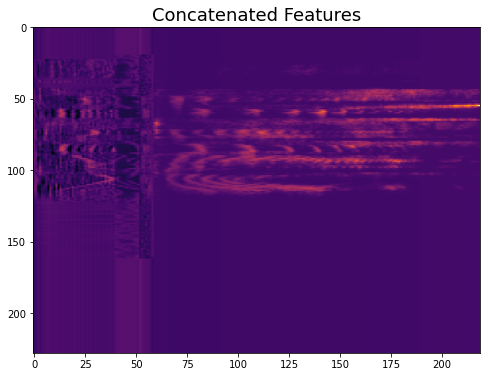

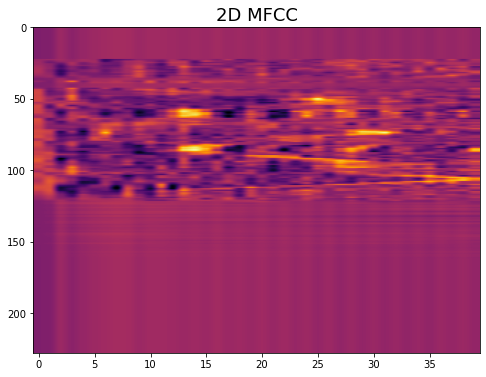

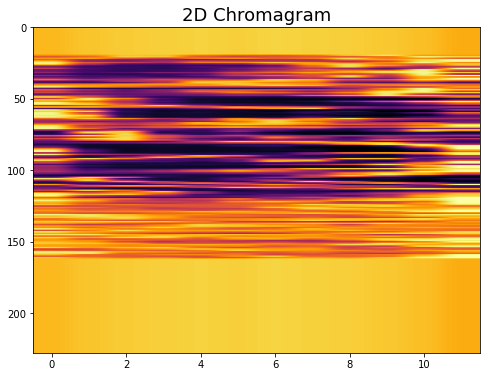

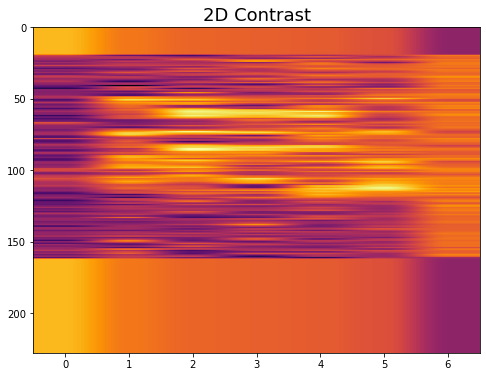

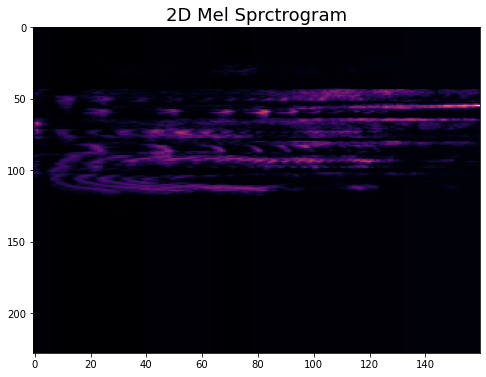

In [5]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/2d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=channel_mean, std= channel_std, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=16, shuffle=False)


imput_dim=(None,None)

for src, tgt in train_dataloader:
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)
    
    print(src.shape)
    
    imput_dim=(src.shape[1], src.shape[2])
#     print(tgt.shape)
#     print(torch.mean(src, axis=1).shape)
    

    print(torch.max(src[0][0]))
    fig=plt.figure(figsize=(8, 6))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("Concatenated Features", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    fig=plt.figure(figsize=(8,6))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("2D MFCC", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,:40], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    
    fig=plt.figure(figsize=(8,6))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("2D Chromagram", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,40:52], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    fig=plt.figure(figsize=(8,6))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("2D Contrast", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,52:59], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    fig=plt.figure(figsize=(8,6))
    # plt.plot(src.cpu().numpy()[1])
    plt.title("2D Mel Sprctrogram", fontsize=18)
    imgplot = plt.imshow(src.cpu().numpy()[1][:,59:219], cmap=plt.get_cmap( 'inferno'),aspect='auto')
    
    
    # print(std)
    # print(src.cpu().numpy()[5])

    break
    
    





## Train Eval functions

In [4]:

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/2d-cnn/'

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    
    val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        logits = model(src)
  
        loss = loss_fn(logits, tgt)
     
        losses += loss.item()
    
    
    
    return losses / len(val_dataloader)



def train_deploy_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train_all',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


## 2D CNN

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_CNN(nn.Module):
    def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_CNN, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        self.hidden_dim=int(self.input_size/2)

        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel 
        self.conv1 = nn.Conv2d(1, 200, (20,5),stride=(1,1), padding=0)
        
        self.conv2 = nn.Conv2d(200, 200, (10,5),stride=(1,1), padding=0)

        # self.conv3 = nn.Conv2d(200, 100, (5,2),stride=(2,2), padding=0)

        self.conv4 = nn.Conv2d(200, 100, (3,3),stride=(1,1), padding=0)

        # self.conv5 = nn.Conv2d(64, 128, 3,stride=(1,1), padding=0)

        # self.conv6 = nn.Conv2d(64, 64, 2,stride=(1,1), padding=0)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(100, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, tgt_class_cnt)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = x.unsqueeze(1)

        x = F.avg_pool2d(F.relu(self.conv1(x)), (6, 2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (6, 2))

        # x = F.dropout(x, 0.2)

        # x = F.max_pool2d(F.relu(self.conv3(x)), (4, 2))
        # x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))

        # x = F.relu(self.conv4(x))
        # x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))

        # x = F.adaptive_avg_pool2d(F.relu(self.conv4(x)), 1)
        x = F.adaptive_max_pool2d(F.relu(self.conv4(x)), 1)

        # x = F.max_pool2d(F.relu(self.conv6(x)), (3, 3))

        x = F.dropout(x, 0.2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        # x = F.dropout(x, 0.1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [6]:
from torchsummary import summary

INPUT_SIZE=INPUT_SIZE=imput_dim[0]*imput_dim[1]
TGT_CLASS_CNT=8
BATCH_SIZE = 8 #128

lr=0.0001
betas=(0.9, 0.98)
eps=1e-9

cnn = Ravdess_CNN(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT, num_of_layers=2)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(cnn)
print( cnn)

for p in cnn.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)

cnn = cnn.to(DEVICE)

# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), lr=lr, betas=betas, eps=eps)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            20,200
├─Conv2d: 1-2                            2,000,200
├─Conv2d: 1-3                            180,100
├─Linear: 1-4                            5,050
├─Linear: 1-5                            408
Total params: 2,205,958
Trainable params: 2,205,958
Non-trainable params: 0
Ravdess_CNN(
  (conv1): Conv2d(1, 200, kernel_size=(20, 5), stride=(1, 1))
  (conv2): Conv2d(200, 200, kernel_size=(10, 5), stride=(1, 1))
  (conv4): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=8, bias=True)
)


In [7]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 100
NORM=None

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.0001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(cnn, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(cnn)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



wandb: Currently logged in as: mohnik (use `wandb login --relogin` to force relogin)


Epoch: 1, Train loss: 5.372, Val loss: 2.437, Epoch time = 8.938s
Epoch: 2, Train loss: 2.275, Val loss: 2.201, Epoch time = 8.878s
Epoch: 3, Train loss: 2.110, Val loss: 2.058, Epoch time = 9.021s
Epoch: 4, Train loss: 2.002, Val loss: 1.833, Epoch time = 9.158s
Epoch: 5, Train loss: 1.936, Val loss: 1.816, Epoch time = 9.179s
Epoch: 6, Train loss: 1.914, Val loss: 1.714, Epoch time = 9.299s
Epoch: 7, Train loss: 1.847, Val loss: 1.931, Epoch time = 9.314s
Epoch: 8, Train loss: 1.796, Val loss: 1.871, Epoch time = 9.531s
Epoch: 9, Train loss: 1.731, Val loss: 1.790, Epoch time = 9.127s
Epoch: 10, Train loss: 1.696, Val loss: 1.701, Epoch time = 8.845s
Epoch: 11, Train loss: 1.659, Val loss: 1.583, Epoch time = 8.943s
Epoch: 12, Train loss: 1.639, Val loss: 1.663, Epoch time = 8.996s
Epoch: 13, Train loss: 1.595, Val loss: 1.544, Epoch time = 9.016s
Epoch: 14, Train loss: 1.590, Val loss: 1.600, Epoch time = 8.934s
Epoch: 15, Train loss: 1.536, Val loss: 1.615, Epoch time = 8.996s
Epoc

FileNotFoundError: [Errno 2] No such file or directory: '/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/2d-cnn/arbitrary/training/03-01-02-02-02-01-02_features.pkl'

## train validation results

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm, train_metrics = get_confusion_matrix(cnn,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

# print(test_cm)
true_pos = np.diag(train_cm)
train_precision = np.sum(true_pos / np.sum(train_cm, axis=0))
train_recall = np.sum(true_pos / np.sum(train_cm, axis=1))


# print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm, val_metrics = get_confusion_matrix(cnn,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)

# print(test_cm)
true_pos = np.diag(val_cm)
val_precision = np.sum(true_pos / np.sum(val_cm, axis=0))
val_recall = np.sum(true_pos / np.sum(val_cm, axis=1))


plot_cm(train_cm)
# print(f'Train accuracy: {train_acc}, precesion: {train_precision}, recall: {train_recall}')
print("train")
print(train_metrics)

plot_cm(val_cm)
# print(f'Val accuracy: {val_acc}, precesion: {val_precision}, recall: {val_recall}')
print("validation")
print(val_metrics)




## Train on the whole training pot

In [ ]:
for p in cnn.parameters():
    if p.dim() > 1:
        nn.init.kaiming_uniform_(p)
        
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr, betas=betas, eps=eps)

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.0001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_deploy_epoch(cnn, optimizer)
    end_time = timer()
 
    # val_loss = evaluate(cnn)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss})

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



## test performance

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn import metrics

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    
    stats=metrics.classification_report(y_true, y_pred, digits=3)

    # print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm, stats

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()


test_iter = RAVDESSFeatureDataset(split='test',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD, feature_2d=True)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=1, shuffle=True)
    
test_cm, test_metrics = get_confusion_matrix(cnn,test_dataloader)
test_acc = (test_cm*np.eye(len(test_cm))).sum()/np.sum(test_cm)

# print(test_cm)
true_pos = np.diag(test_cm)
test_precision = np.sum(true_pos / np.sum(test_cm, axis=0))
test_recall = np.sum(true_pos / np.sum(test_cm, axis=1))


plot_cm(test_cm)
# print(f'Test accuracy: {test_acc}, precesion: {test_precision}, recall: {test_recall}')
print("test")
print(test_metrics)

